In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
df = pd.read_csv("train.csv")

df.head()

,Customer_ID,Age,Gender,Location,Subscription_Type,Account_Age_Months,Monthly_Spending,Total_Usage_Hours,Support_Calls,Late_Payments,Streaming_Usage,Discount_Used,Satisfaction_Score,Last_Interaction_Type,Complaint_Tickets,Promo_Opted_In,Churn
0,1001,19,Male,Illinois,Basic,50,152.44,416,5,2,61,76,3,Neutral,0,1,1
1,1002,41,Male,California,Premium,14,113.34,36,5,1,17,90,5,Negative,3,0,0
2,1003,44,Female,Florida,Basic,2,168.39,207,3,1,85,12,6,Neutral,3,0,1
3,1004,21,Male,Florida,Basic,55,197.12,379,4,3,54,32,4,Positive,3,1,0
4,1005,65,Male,New York,Premium,12,84.46,475,5,4,82,62,1,Neutral,0,0,1


In [7]:
df.shape

(8000, 17)

In [8]:
df.describe()

,Customer_ID,Age,Account_Age_Months,Monthly_Spending,Total_Usage_Hours,Support_Calls,Late_Payments,Streaming_Usage,Discount_Used,Satisfaction_Score,Complaint_Tickets,Promo_Opted_In,Churn
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5000.50000,43.542250,30.163875,104.804641,254.326625,4.45325,1.99250,49.798000,49.428250,5.462375,1.970500,0.499750,0.313125
std,2309.54541,14.909242,16.942407,54.643255,140.855632,2.88892,1.39971,28.965468,28.662071,2.879865,1.413375,0.500031,0.463794
min,1001.00000,18.000000,1.000000,10.090000,10.000000,0.00000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3000.75000,31.000000,15.000000,57.637500,133.000000,2.00000,1.00000,24.000000,25.000000,3.000000,1.000000,0.000000,0.000000
50%,5000.50000,44.000000,30.000000,104.690000,256.500000,4.00000,2.00000,51.000000,50.000000,5.000000,2.000000,0.000000,0.000000
75%,7000.25000,57.000000,45.000000,151.697500,376.000000,7.00000,3.00000,75.000000,74.000000,8.000000,3.000000,1.000000,1.000000
max,9000.00000,69.000000,59.000000,199.940000,499.000000,9.00000,4.00000,99.000000,99.000000,10.000000,4.000000,1.000000,1.000000


In [13]:
columns = df.columns

for col in columns:
    if df[col].dtype == "object" :
        print(f"{col} = {df[col].unique()}")

Gender = ['Male' 'Female']
Location = ['Illinois' 'California' 'Florida' 'New York' 'Texas']
Subscription_Type = ['Basic' 'Premium' 'Enterprise']
Last_Interaction_Type = ['Neutral' 'Negative' 'Positive']


In [15]:
df.isnull().sum()

Customer_ID              0
Age                      0
Gender                   0
Location                 0
Subscription_Type        0
Account_Age_Months       0
Monthly_Spending         0
Total_Usage_Hours        0
Support_Calls            0
Late_Payments            0
Streaming_Usage          0
Discount_Used            0
Satisfaction_Score       0
Last_Interaction_Type    0
Complaint_Tickets        0
Promo_Opted_In           0
Churn                    0
dtype: int64

In [17]:
#heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols

# Fit the OLS model
model = ols(formula='Churn~Satisfaction_Score', data=df).fit()

white_test = het_white(model.resid,  model.model.exog)
bp_test = het_breuschpagan(model.resid, model.model.exog)

output_df = pd.DataFrame(columns=['LM stat', 'LM p-value', 'F-stat', 'F p-value'])
output_df.loc['White'] = white_test
output_df.loc['Breusch-Pagan'] = bp_test

output_df.round(3)

,LM stat,LM p-value,F-stat,F p-value
White,3.183,0.204,1.591,0.204
Breusch-Pagan,3.154,0.076,3.155,0.076


### The tests confirm that there is no significant heteroscedasticity present in the data.

In [22]:
Male = df[df["Gender"] == "Male"]
Female = df[df["Gender"] == "Female"]

t, p = stats.ttest_ind(Male["Churn"],Female["Churn"])
print(f"Gender : t-statistic = {t} , p-value = {p}")


Gender : t-statistic = -0.7974781446195597 , p-value = 0.4251970654860474


### p-value > 0.05 , we can't reject the null hypothesis

In [23]:
def Anova(feature,label):
    groups = df[feature].unique()
    group_values = []
    for group in groups :
        group_values.append(df[df[feature]==group][label])
    # Run independent t-test
    return stats.f_oneway(*group_values) 

for col in df.select_dtypes("object"):
    if df[col].nunique() > 2:
        print(f"{col}: {Anova(col,'Churn')}")


Location: F_onewayResult(statistic=0.9295525297451745, pvalue=0.44554076154838107)
Subscription_Type: F_onewayResult(statistic=0.07246423172415492, pvalue=0.9300996248263421)
Last_Interaction_Type: F_onewayResult(statistic=0.17039692406312415, pvalue=0.8433330740190148)


### all p-values are much greater than 0.05 , the Anova test didn't find meaningful relation between categorical features and the customers Churn 

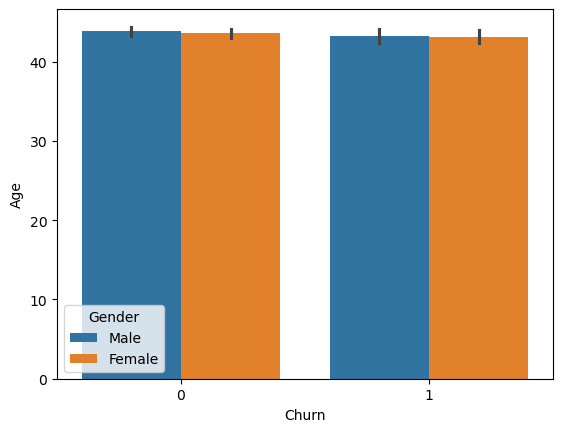

In [ ]:
sns.barplot(data=df,x="Churn",y="Age",hue="Gender")
plt.show()
# 1 : customer left , 0 : cutomer stayed

### The plot shows no significant impact of gender and Age on the Customers churn

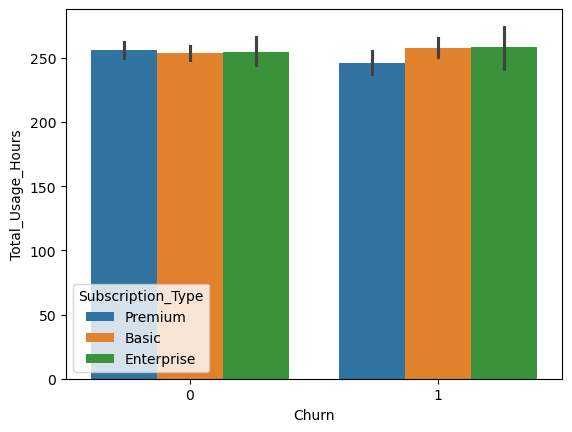

In [29]:
sns.barplot(data=df,x="Churn",y="Total_Usage_Hours",hue="Subscription_Type")
plt.show()

### The plot reveals that, on average, churned customers with a premium subscription had the lowest total usage hours among all customer groups.It refears to people who pay premium services and don't even use it

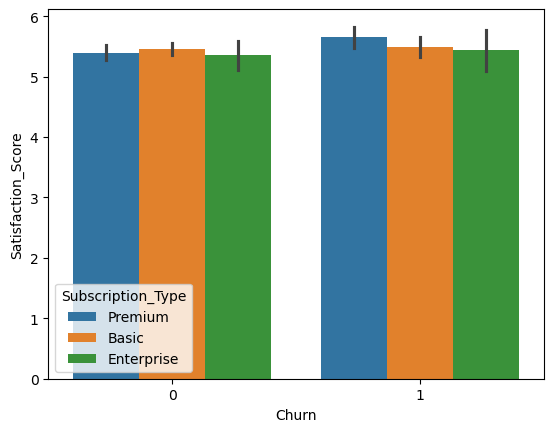

In [35]:
sns.barplot(data=df,x="Churn",y="Satisfaction_Score",hue="Subscription_Type")
plt.show()

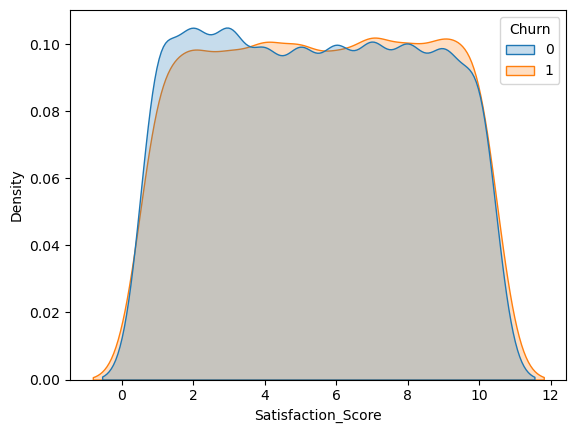

In [36]:
sns.kdeplot(data=df, x="Satisfaction_Score", hue="Churn", fill=True, common_norm=False)
plt.show()

### the barplot and KDEplot indicate that the Satisfaction_Score is not a good metric to predict churn

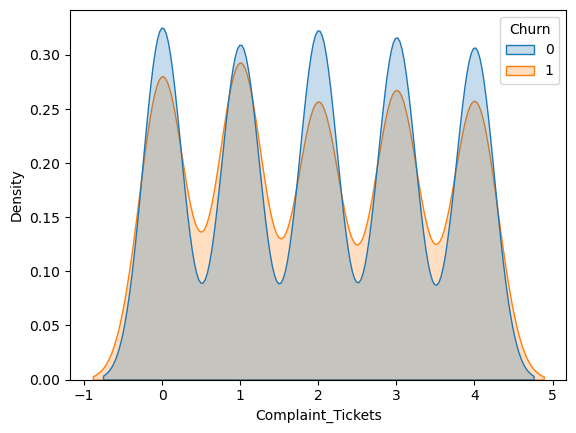

In [39]:
sns.kdeplot(data=df, x="Complaint_Tickets", hue="Churn", fill=True, common_norm=False)
plt.show()

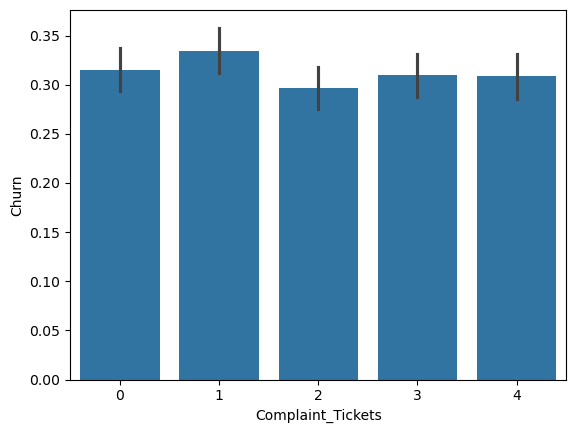

In [40]:
sns.barplot(data=df,x="Complaint_Tickets",y="Churn")
plt.show()

### The plot confirms the meaningful relation between churn and number of complaints, as it shows the customers with multiple complaints are less likely to churn because they are actively and invested enough to provide feedback.

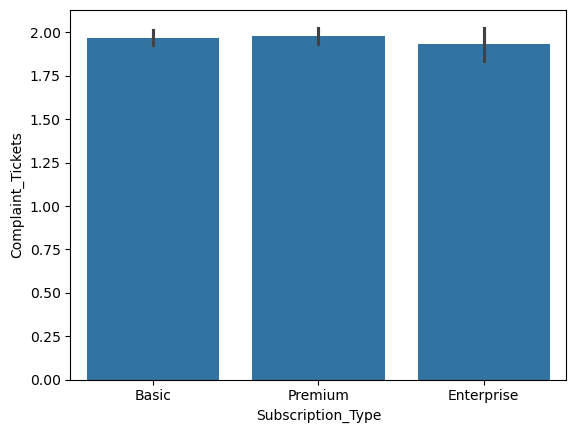

In [ ]:
sns.barplot(data=df,x="Subscription_Type",y="Complaint_Tickets")
plt.show()

### the plot shows that the averge number of complaints is relatively the same for all type of customer

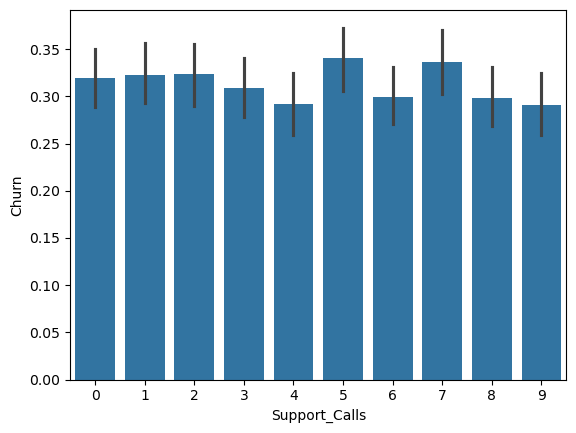

In [49]:
sns.barplot(data=df,x="Support_Calls",y="Churn")
plt.show()

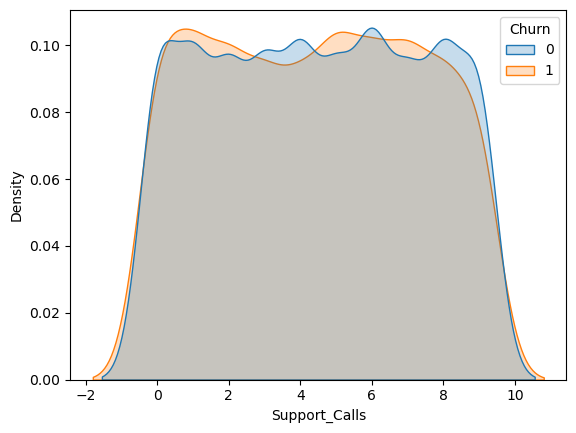

In [44]:
sns.kdeplot(data=df, x="Support_Calls", hue="Churn", fill=True, common_norm=False)
plt.show()

### the plots shows that support calls is not a good indicator in predicting churn

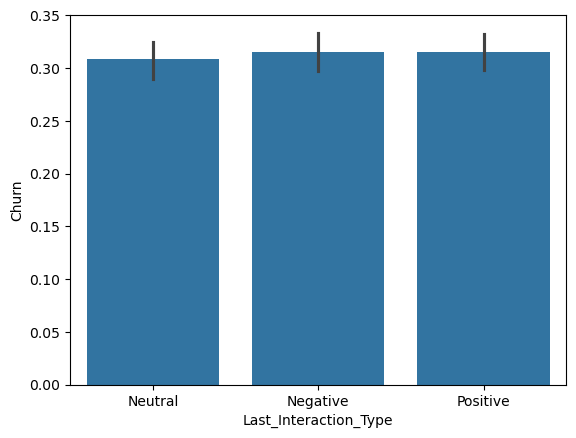

In [50]:
sns.barplot(data=df,x="Last_Interaction_Type",y="Churn")
plt.show()

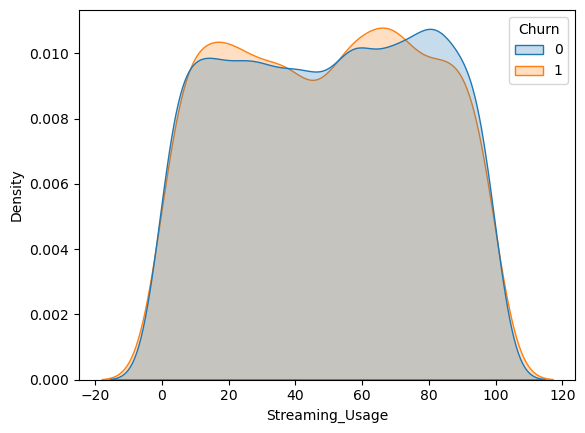

In [55]:
sns.kdeplot(data=df, x="Streaming_Usage", hue="Churn", fill=True, common_norm=False)
plt.show()

### the plots show no clear relation betwenn both (Last_Interaction_Type,Streaming_Usage) and Churn

# Conclusion :

## insights :

### Noise (feature to drop) :

#### - Gender (t-test p-value = 0.42)

#### - Location (ANOVA p-value = 0.44)

#### - Last_Interaction_Type (ANOVA p-value = 0.84)

#### - Age (Bar plot showed no difference)

#### - Satisfaction_Score (KDE plot showed total overlap)

#### - Streaming_Usage (KDE plot showed total overlap)

### features to keep & engineer :

#### - Total_Usage_Hours

#### - Subscription_Type 

#### - Complaint_Tickets 

#### - Support_Calls 